# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
!gunzip gkmexplain_positives_impscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/c8ebc38/modisco/gkmexplain_scores/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
!gunzip gkmexplain_dnshuff_impscores.txt.gz

--2020-04-15 02:15:28--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-15 02:15:28 (2.00 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-15 02:15:29--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000384 (977K) [application/octet-stream]
Saving to: 'gkmexplain_positives_impscores.txt.gz'

100%[=========

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


NOTE: in the original GkmExplain paper, a normalization of the importance scores and hypothetical importance scores was proposed, as this was empirically observed to improve the signal-to-noise ratio. For simplicity, we are not applying that normalization here. For details on that normalization, see the Nanog TF-MoDISco notebook in the GkmExplain repo: https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb

Sanity check the scores by plotting

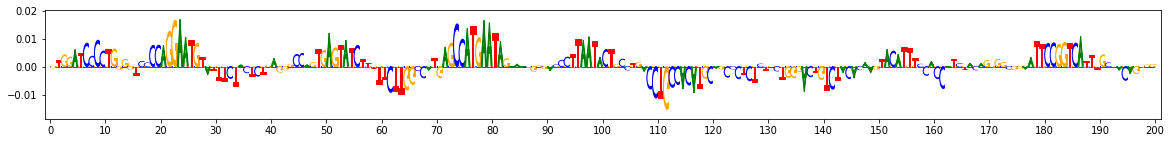

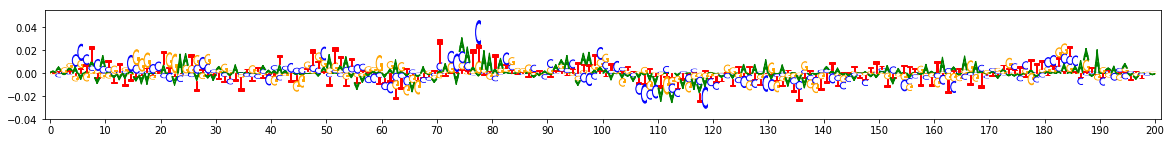

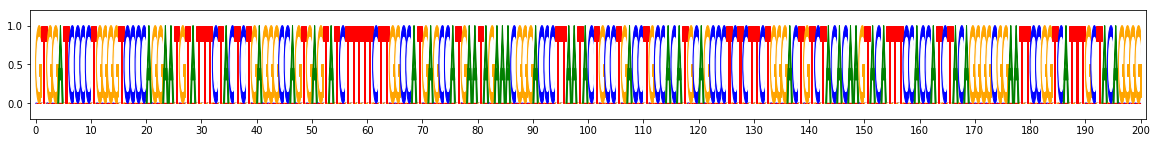

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

MEMORY 0.633065472
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.32632443699999997  and  0.26635030000000004
Final raw thresholds are -0.32632443699999997  and  0.26635030000000004
Final transformed thresholds are -0.9486284722222222  and  0.9078125


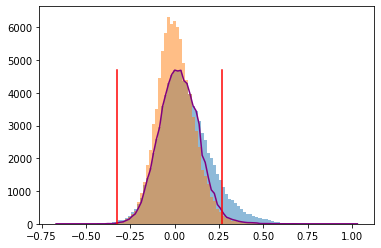

Got 974 coords
After resolving overlaps, got 974 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9077125
MEMORY 0.645599232
974 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [936]
Idx to activities:  {0: '1'}
MEMORY 0.645599232
On metacluster 0
Metacluster size 936
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod anr -nmotifs 5 -minw 6 -maxw 50 -oc meme_out/metacluster0
Of 936 seqlets, cluster assignments are: Counter({0: 311, 1: 211, 2: 193, 3: 146, 4: 50, -1: 25})
Aggregating for cluster 0 with 311 seqlets
MEMORY 0.66281472
Trimmed 17 out of 311
Skipped 39 seqlets
Aggregating for cluster 1 with 211 seqlets
MEMORY 0.663339008
Trimmed 6 out of 211
Skipped 35 seqlets
Aggregating for cluster 2 with 193 seqlets
MEMORY 0.663339008
Trimmed 10 out of 193
Skipped 30 seqlets
Aggregating for c


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6777464301648768



 10%|█         | 5/50 [00:00<00:06,  6.73it/s]

Quality: 0.6788665201625591



100%|██████████| 50/50 [00:08<00:00,  5.71it/s]

Got 8 clusters after round 1
Counts:
{0: 211, 4: 82, 1: 202, 2: 170, 6: 32, 3: 149, 5: 35, 7: 4}
MEMORY 0.67493888
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.67493888
Aggregating for cluster 0 with 211 seqlets
MEMORY 0.67493888


Trimmed 6 out of 211
Skipped 33 seqlets
Aggregating for cluster 1 with 202 seqlets
MEMORY 0.67493888
Trimmed 9 out of 202
Skipped 18 seqlets
Aggregating for cluster 2 with 170 seqlets
MEMORY 0.67493888
Trimmed 8 out of 170
Skipped 30 seqlets
Aggregating for cluster 3 with 149 seqlets
MEMORY 0.67493888
Trimmed 6 out of 149
Skipped 23 seqlets
Aggregating for cluster 4 with 82 seqlets
MEMORY 0.67493888
Trimmed 3 out of 82
Skipped 12 seqlets
Aggregating for cluster 5 with 35 seqlets
MEMORY 0.67493888
Trimmed 2 out of 35
Skipped 6 seqlets
Aggregating for cluster 6 with 32 seqlets
MEMORY 0.67493888
Trimmed 0 out of 32
Skipped 4 seqlets
Aggregating for cluster 7 with 4 seqlets
MEMORY 0.67493888
Trimmed 0 out of 4
Of 725 seqlets, cluster assignments are: Counter({0: 248, 1: 169, 2: 144, 3: 124, 4: 33, -1: 7})
Aggregating for cluster 0 with 248 seqlets
MEMORY 0.693448704
Trimmed 79 out of 248
Aggregating for cluster 1 with 169 seqlets
MEMORY 0.693542912
Trimmed 9 out of 169
Aggregating for clus


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6201512162707721



  6%|▌         | 3/50 [00:00<00:07,  6.34it/s]

Quality: 0.6209825915771056



 32%|███▏      | 16/50 [00:02<00:05,  5.73it/s]

Quality: 0.6215129385790278



100%|██████████| 50/50 [00:07<00:00,  6.49it/s]

Got 8 clusters after round 2
Counts:
{1: 147, 6: 42, 5: 65, 3: 99, 2: 119, 4: 78, 0: 173, 7: 2}
MEMORY 0.679931904
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.679931904
Aggregating for cluster 0 with 173 seqlets
MEMORY 0.679931904


Trimmed 17 out of 173
Aggregating for cluster 1 with 147 seqlets
MEMORY 0.679931904
Trimmed 19 out of 147
Aggregating for cluster 2 with 119 seqlets
MEMORY 0.679931904
Trimmed 15 out of 119
Aggregating for cluster 3 with 99 seqlets
MEMORY 0.679931904
Trimmed 10 out of 99
Aggregating for cluster 4 with 78 seqlets
MEMORY 0.679931904
Trimmed 25 out of 78
Skipped 1 seqlets
Aggregating for cluster 5 with 65 seqlets
MEMORY 0.679931904
Trimmed 6 out of 65
Skipped 5 seqlets
Aggregating for cluster 6 with 42 seqlets
MEMORY 0.679936
Trimmed 7 out of 42
Skipped 1 seqlets
Aggregating for cluster 7 with 2 seqlets
MEMORY 0.679936
Trimmed 0 out of 2
Got 8 clusters
Splitting into subclusters...
MEMORY 0.679862272
Inspecting for spurious merging
Wrote graph to binary file in 0.06904196739196777 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00522204
After 4 runs, maximum modularity is Q = 0.00522205
Louvain completed 24 runs in 0.42501020431518555 seconds
Simi

In [32]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",            
                        num_seqlets_to_use=10000, nmotifs=5, n_jobs=1),
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [33]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


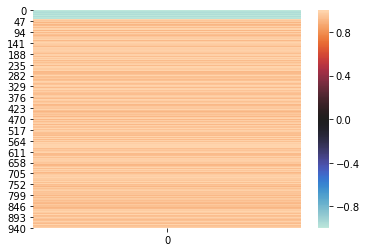

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 198
Hypothetical scores:


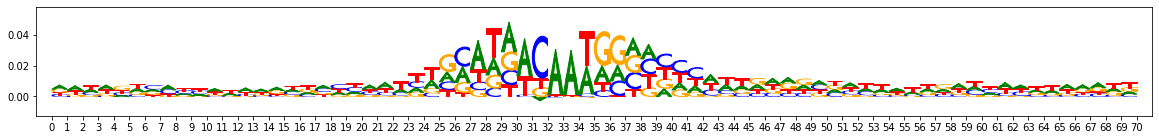

Actual importance scores:


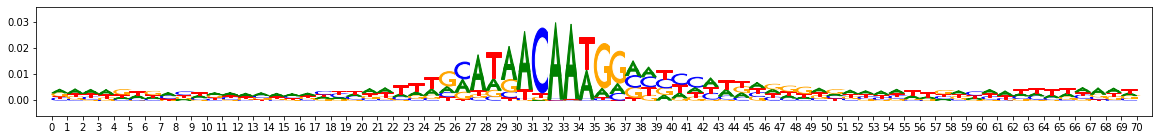

onehot, fwd and rev:


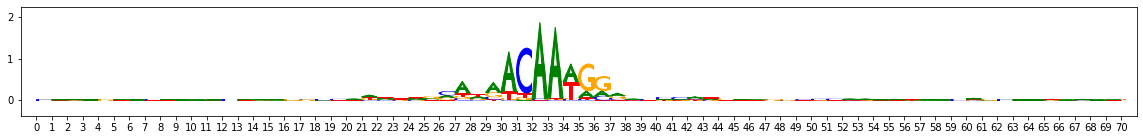

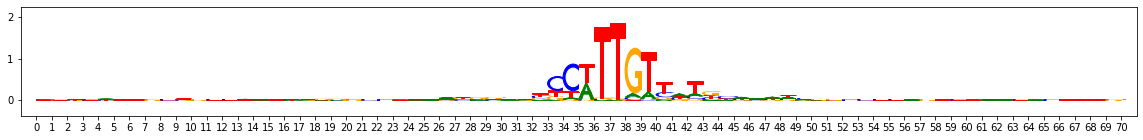

metacluster_0 pattern_1
total seqlets: 173
Hypothetical scores:


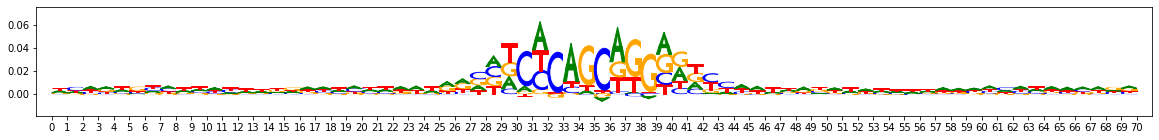

Actual importance scores:


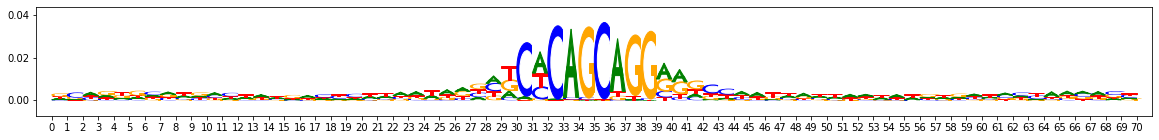

onehot, fwd and rev:


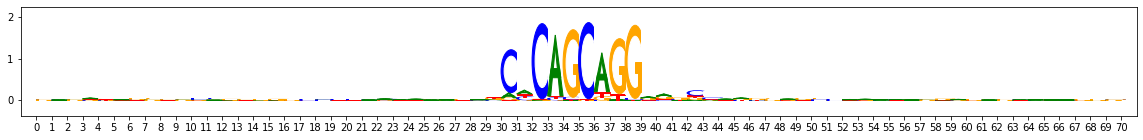

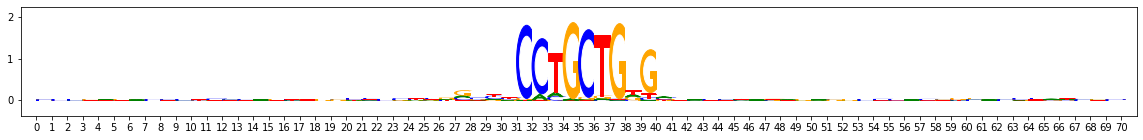

metacluster_0 pattern_2
total seqlets: 163
Hypothetical scores:


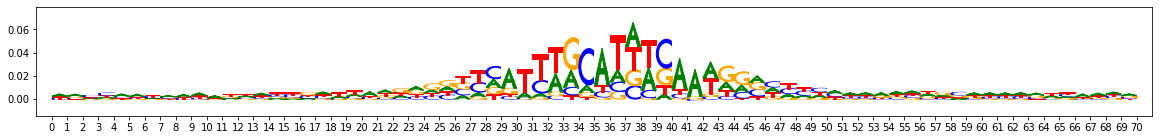

Actual importance scores:


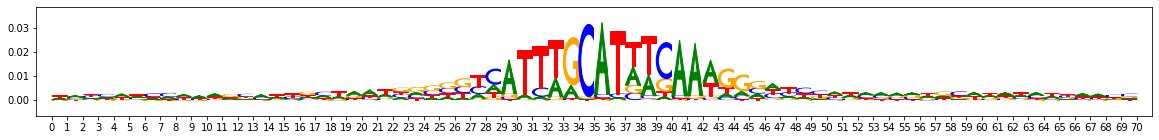

onehot, fwd and rev:


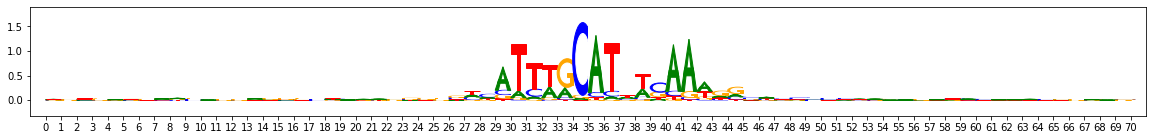

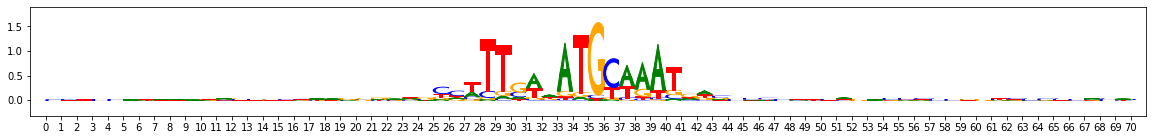

In [34]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

MEME-DISco motif number 0
num seqlets: 255


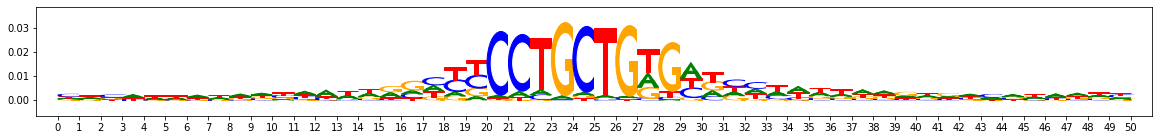

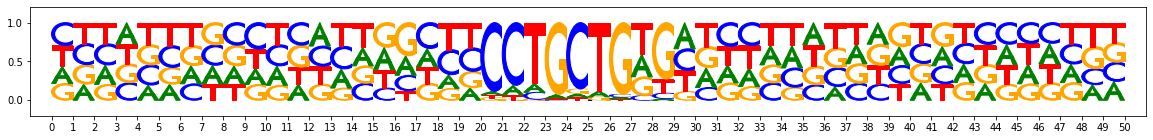

MEME-DISco motif number 1
num seqlets: 170


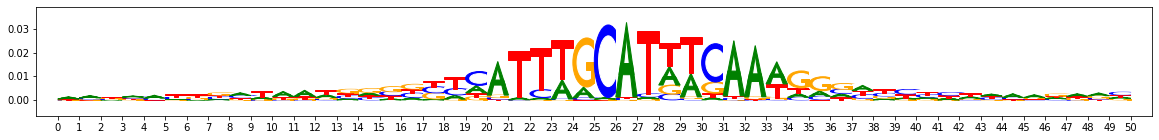

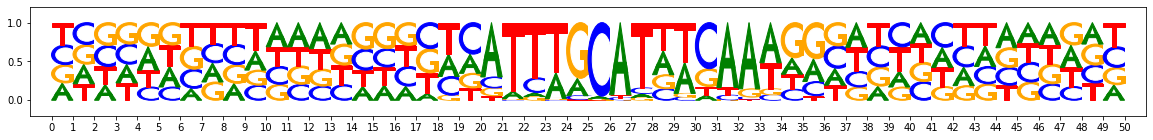

MEME-DISco motif number 2
num seqlets: 153


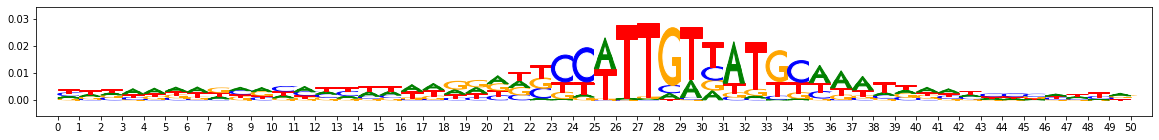

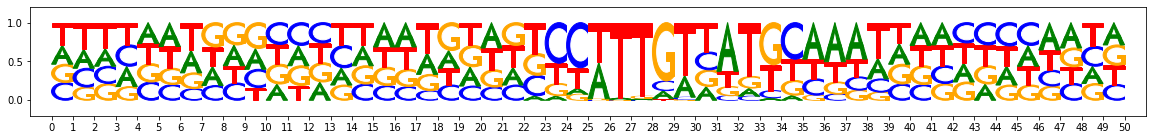

MEME-DISco motif number 3
num seqlets: 119


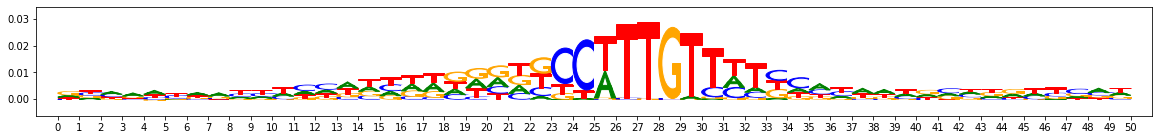

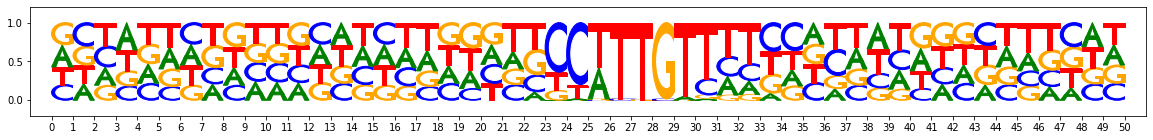

MEME-DISco motif number 4
num seqlets: 41


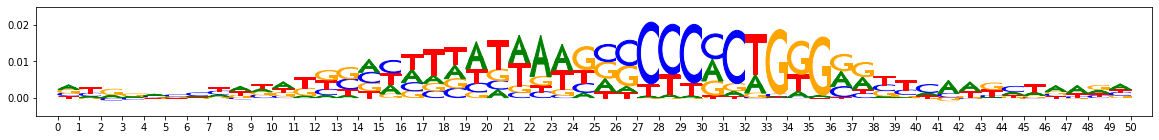

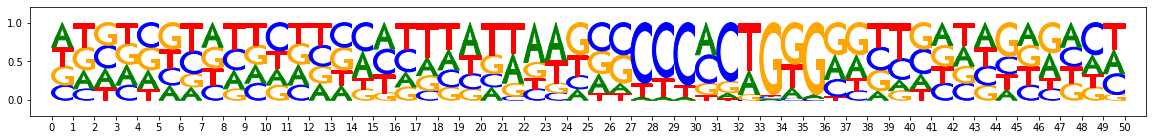

In [41]:
from modisco.visualization import viz_sequence
meme_discovered_motifs = (tfmodisco_results
    .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
    .each_round_initcluster_motifs[0])
for idx,motif in enumerate(meme_discovered_motifs):
    print("MEME-DISco motif number",idx)
    print("num seqlets:",len(motif.seqlets))
    viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
    viz_sequence.plot_weights(motif["sequence"].fwd)